#Inference on SNLI with GloVe Embeddings + BiLSTM

### Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import random
import numpy as np

import time

import matplotlib.pyplot as plt

In [ ]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 8.6 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


### Set random seed

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Import data

In [ ]:
TEXT = data.Field(tokenize = 'spacy', lower = True)
LABEL = data.LabelField()

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
train_data, valid_data, test_data = datasets.SNLI.splits(TEXT, LABEL)

In [ ]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 549367
Number of validation examples: 9842
Number of testing examples: 9824


In [ ]:

BATCH_SIZE = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

### Build vocabulary

In [ ]:

MIN_FREQ = 2

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

Frame the model

In [ ]:
class Model(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim,
                 hidden_dim,
                 n_lstm_layers,
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
                                
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.translation = nn.Linear(embedding_dim, hidden_dim)
        
        self.lstm = nn.LSTM(hidden_dim, 
                            hidden_dim, 
                            num_layers = n_lstm_layers, 
                            bidirectional = True, 
                            dropout=dropout)
        
        com_dim = hidden_dim * 2

        self.dense1 = nn.Linear(com_dim * 2, com_dim * 4)
        self.dense2 = nn.Linear(com_dim * 4, com_dim * 8)
        self.dense3 = nn.Linear(com_dim * 8, com_dim * 4)
        self.dense4 = nn.Linear(com_dim * 4, com_dim * 2)
        
        self.out = nn.Linear(com_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, prem, hypo):

        prem_seq_len, batch_size = prem.shape
        hypo_seq_len, _ = hypo.shape
        
        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]
        
        embedded_prem = self.embedding(prem)
        embedded_hypo = self.embedding(hypo)
        
        #embedded_prem = [prem sent len, batch size, embedding dim]
        #embedded_hypo = [hypo sent len, batch size, embedding dim]
        
        translated_prem = F.relu(self.translation(embedded_prem))
        translated_hypo = F.relu(self.translation(embedded_hypo))
        
        #translated_prem = [prem sent len, batch size, hidden dim]
        #translated_hypo = [hypo sent len, batch size, hidden dim]
        
        outputs_prem, (hidden_prem, cell_prem) = self.lstm(translated_prem)
        outputs_hypo, (hidden_hypo, cell_hypo) = self.lstm(translated_hypo)

        #outputs_x = [sent len, batch size, n directions * hid dim]
        #hidden_x = [n layers * n directions, batch size, hid dim]
        #cell_x = [n layers * n directions, batch size, hid dim]
        
        hidden_prem = torch.cat((hidden_prem[-1], hidden_prem[-2]), dim=-1)
        hidden_hypo = torch.cat((hidden_hypo[-1], hidden_hypo[-2]), dim=-1)
        
        #hidden_x = [batch size, fc dim]

        hidden = torch.cat((hidden_prem, hidden_hypo), dim=1)

        #hidden = [batch size, fc dim * 2]
            
        
        hidden = self.dense1(hidden)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)
        hidden = self.dense2(hidden)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)
        hidden = self.dense3(hidden)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)
        hidden = self.dense4(hidden)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)
        
        prediction = self.out(hidden)
        
        #prediction = [batch size, output dim]
        
        return prediction

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
N_LSTM_LAYERS = 2
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = Model(INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              N_LSTM_LAYERS,
              OUTPUT_DIM,
              DROPOUT,
              PAD_IDX).to(device) #Send model to cuda

### Import embeddings and freeze training

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 39,584,103 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([23566, 300])


In [ ]:

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ..., -1.4447,  0.8402, -0.8668],
        [ 0.1032, -1.6268,  0.5729,  ...,  0.3180, -0.1626, -0.0417],
        [-0.2971,  0.0940, -0.0967,  ...,  0.0597, -0.2285,  0.2960],
        ...,
        [-0.2149,  0.0846, -0.2949,  ...,  0.2379,  0.4804, -0.3348],
        [-0.2983, -0.2664, -0.0631,  ..., -0.1577,  1.0438, -0.6433],
        [ 0.3580, -0.0304,  0.3355,  ...,  0.0703, -0.5158,  0.1819]],
       device='cuda:0')

In [ ]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[-0.1117, -0.4966,  0.1631,  ..., -1.4447,  0.8402, -0.8668],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2971,  0.0940, -0.0967,  ...,  0.0597, -0.2285,  0.2960],
        ...,
        [-0.2149,  0.0846, -0.2949,  ...,  0.2379,  0.4804, -0.3348],
        [-0.2983, -0.2664, -0.0631,  ..., -0.1577,  1.0438, -0.6433],
        [ 0.3580, -0.0304,  0.3355,  ...,  0.0703, -0.5158,  0.1819]],
       device='cuda:0')


In [ ]:
model.embedding.weight.requires_grad = False

In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 32,514,303 trainable parameters


### Train the model

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def categorical_accuracy(preds, y):
    
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    correct = correct.to('cpu')
    y = y.to('cpu')
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        prem = batch.premise
        hypo = batch.hypothesis
        labels = batch.label
        
        optimizer.zero_grad()
        
        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]
        
        predictions = model(prem, hypo)
        
        #predictions = [batch size, output dim]
        #labels = [batch size]
        
        loss = criterion(predictions, labels)
                
        acc = categorical_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            prem = batch.premise
            hypo = batch.hypothesis
            labels = batch.label
                        
            predictions = model(prem, hypo)
            
            loss = criterion(predictions, labels)
                
            acc = categorical_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
tr_loss = []
vl_loss = []
tr_acc = []
vl_acc = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    tr_loss.append(train_loss)
    vl_loss.append(valid_loss)
    tr_acc.append(train_acc)
    vl_acc.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 21s
	Train Loss: 0.795 | Train Acc: 64.09%
	 Val. Loss: 0.683 |  Val. Acc: 71.57%
Epoch: 02 | Epoch Time: 3m 21s
	Train Loss: 0.641 | Train Acc: 73.39%
	 Val. Loss: 0.605 |  Val. Acc: 74.84%
Epoch: 03 | Epoch Time: 3m 21s
	Train Loss: 0.582 | Train Acc: 76.43%
	 Val. Loss: 0.556 |  Val. Acc: 77.20%
Epoch: 04 | Epoch Time: 3m 24s
	Train Loss: 0.539 | Train Acc: 78.45%
	 Val. Loss: 0.533 |  Val. Acc: 78.36%
Epoch: 05 | Epoch Time: 3m 21s
	Train Loss: 0.507 | Train Acc: 79.94%
	 Val. Loss: 0.519 |  Val. Acc: 78.83%
Epoch: 06 | Epoch Time: 3m 21s
	Train Loss: 0.480 | Train Acc: 81.14%
	 Val. Loss: 0.503 |  Val. Acc: 80.13%
Epoch: 07 | Epoch Time: 3m 22s
	Train Loss: 0.453 | Train Acc: 82.32%
	 Val. Loss: 0.497 |  Val. Acc: 80.76%
Epoch: 08 | Epoch Time: 3m 21s
	Train Loss: 0.427 | Train Acc: 83.43%
	 Val. Loss: 0.499 |  Val. Acc: 80.79%
Epoch: 09 | Epoch Time: 3m 21s
	Train Loss: 0.402 | Train Acc: 84.52%
	 Val. Loss: 0.490 |  Val. Acc: 81.30%
Epoch: 10 | Epoch T

In [ ]:

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.502 |  Test Acc: 80.37%


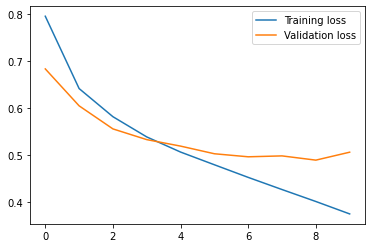

In [ ]:
plt.plot(tr_loss, label = "Training loss")
plt.plot(vl_loss, label = "Validation loss")
plt.legend()
plt.show()

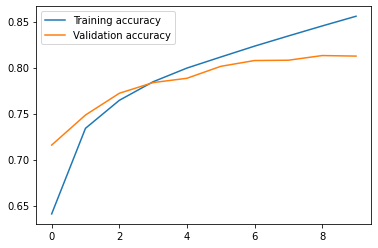

In [ ]:
plt.plot(tr_acc, label = "Training accuracy")
plt.plot(vl_acc, label = "Validation accuracy")
plt.legend()
plt.show()